### This notebooks enables visualization of the image chips and corresponding masks

- [x] 0. Dataset & dataloader
- [x] 1. visualize multiple samples for tile

In [1]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.
# Written by Simone Fobi


import sys, os

sys.path.append("..")
from data.streaming_line_dataset import StreamingGeospatialDataset
from omegaconf import OmegaConf
import torch
import glob
import kornia.augmentation as K
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.pyplot
import scipy.ndimage

In [2]:
config = OmegaConf.load("../line_config.yaml")

Let's set up some support classes & functions for accessing the dataset

In [3]:
DEFAULT_AUGS = K.AugmentationSequential(
    K.RandomRotation(p=0.5, degrees=90),
    K.RandomHorizontalFlip(p=0.5),
    K.RandomVerticalFlip(p=0.5),
    K.ColorJitter(p=0.5, brightness=0.5, contrast=0.5, saturation=0.5),
    data_keys=["image", "mask"],
)

REFINEMENT_AUGS = K.AugmentationSequential(
    K.RandomRotation(p=0.5, degrees=90),
    K.RandomHorizontalFlip(p=0.5),
    K.RandomVerticalFlip(p=0.5),
    data_keys=["image", "mask"],
)


def get_fns(base_dir, split):
    """Get the filenames for the given split.

    Args:
        base_dir (str): The base directory name containing the split directories.
        split (str): The split to get the image filenames for.

    Returns:
        list: A list of image filenames for the given split.
    """
    filenames = glob.glob(base_dir + split + "/*.tif")
    return sorted(filenames)


def nodata_check(label):
    """Check if the label is all nodata.

    Args:
        label (array): Input label array.

    Returns:
        bool : True if the label is all nodata, False otherwise.
    """
    flag = False
    if np.sum(label) == 0:
        flag = True
    return flag


class Preprocessor:
    """Data preprocessing: normalize and standardize the data."""

    def __init__(self, img_mean, img_std, standardize=False) -> None:
        self.img_min = img_mean
        self.img_max = img_std
        self.standardize = standardize

    def __call__(self, sample):

        # Perform mean-std standardization
        if self.standardize:
            sample["image"][:3] = (sample["image"][:3] - self.img_mean) / self.img_std
        else:
            # RGB is uint8 so divide by 255
            sample["image"] = (
                torch.from_numpy(sample["image"]).type(torch.FloatTensor) / 255.0
            )

        return sample

Set up the dataloaders

In [4]:
img_mean: list = [75.006010333223, 68.318348580367, 63.633123192871]
img_std: list = [76.842842915691, 70.10749190534, 65.514465248706]
transforms = T.Compose([Preprocessor(img_mean, img_std)])
train_img_fns = get_fns(config["datamodule"]["root_dir"], "train_images")
train_label_fns = get_fns(config["datamodule"]["root_dir"], "train_masks_lines")
train_ds = StreamingGeospatialDataset(
    train_img_fns,
    train_label_fns,
    chip_size=config["datamodule"]["chip_size"],
    num_chips_per_tile=25,
    image_transform=transforms,
    image_augmentation=DEFAULT_AUGS,
    verbose=False,
    nodata_check=nodata_check,
    kernel_size=config["datamodule"]["segm_filter_size"],
    input_channels=config["learning"]["in_channels"],
)


val_img_fns = get_fns(config["datamodule"]["root_dir"], "val_images")
val_label_fns = get_fns(config["datamodule"]["root_dir"], "val_masks_lines")
val_ds = StreamingGeospatialDataset(
    val_img_fns,
    val_label_fns,
    chip_size=config["datamodule"]["chip_size"],
    num_chips_per_tile=25,
    image_transform=transforms,
    image_augmentation=DEFAULT_AUGS,
    verbose=False,
    nodata_check=nodata_check,
    kernel_size=config["datamodule"]["segm_filter_size"],
    input_channels=config["learning"]["in_channels"],
)


train_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=config["datamodule"]["batch_size"],
    num_workers=config["datamodule"]["num_workers"],
    pin_memory=True,
)
val_loader = torch.utils.data.DataLoader(
    val_ds,
    batch_size=config["datamodule"]["batch_size"],
    num_workers=config["datamodule"]["num_workers"],
    pin_memory=True,
)

Access the dataset

In [5]:
img, mask = list(), list()
for n_iter, (batch) in enumerate(val_loader):
    imgs, masks = batch["image"], batch["mask"]
    img.append(imgs.numpy())
    mask.append(masks.numpy())

Define a plotting function to visualize samples

In [ ]:
## define the function to show an image
def plot_array_list(imgs, masks):
    """Plot a list of images and masks"""
    rows = 5
    cols = 2 * rows
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(80, 80))
    cmap = matplotlib.cm.get_cmap("tab20")

    for idx, (img, mask) in enumerate(zip(imgs, masks)):
        row, col = divmod(idx, rows)

        # Plot original image
        axs[row, col * 2].imshow(np.rollaxis(img, 0, 3))
        axs[row, col * 2].axis("off")
        new_img = np.rollaxis(img.copy(), 0, 3)
        resized_mask = scipy.ndimage.zoom(np.rollaxis(mask, 0, 3)[:, :, 0], 8, order=1)
        new_img[resized_mask > 0.5, 0] = 1
        # Plot the mask
        axs[row, col * 2 + 1].imshow(new_img)
        axs[row, col * 2 + 1].axis("off")

    plt.show()

Plot a large sample 

In [ ]:
plot_array_list(np.concatenate(img[:25]), np.concatenate(mask[:25]))

Zooming in a little to better see the lines

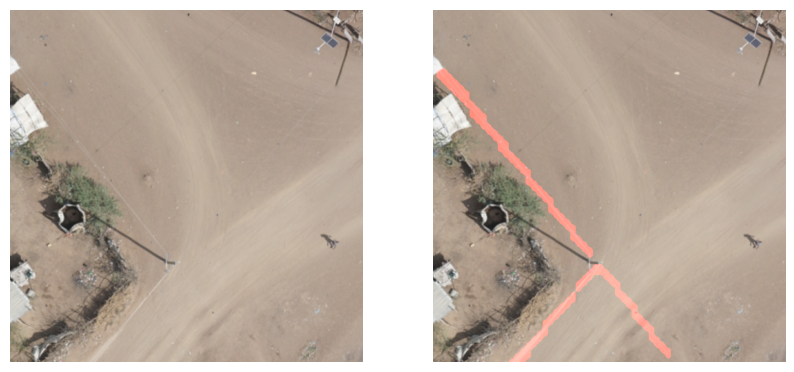

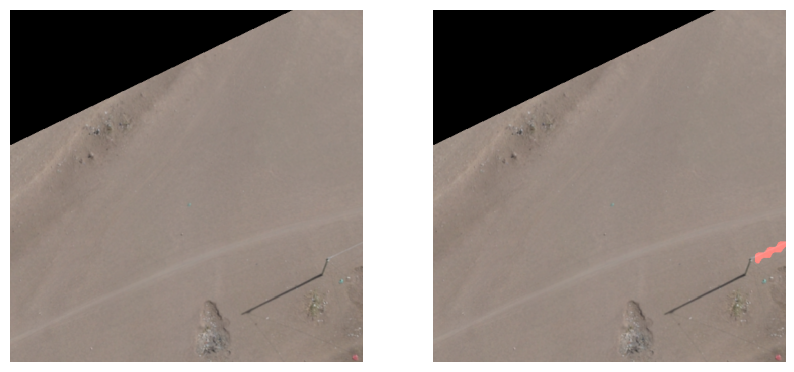

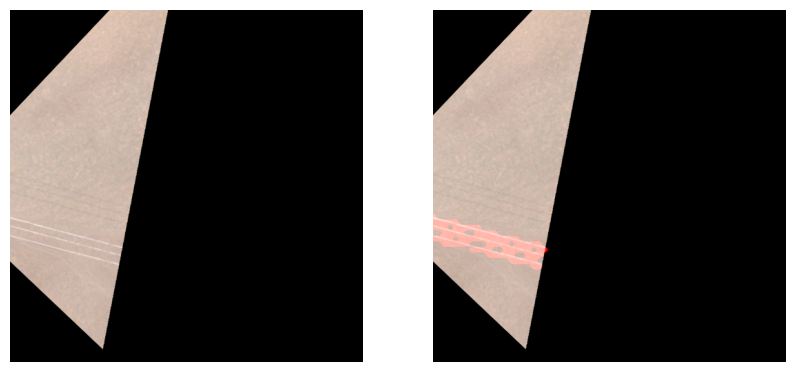

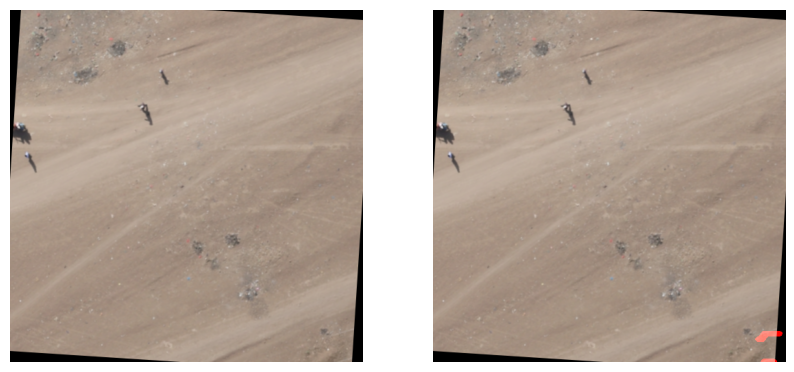

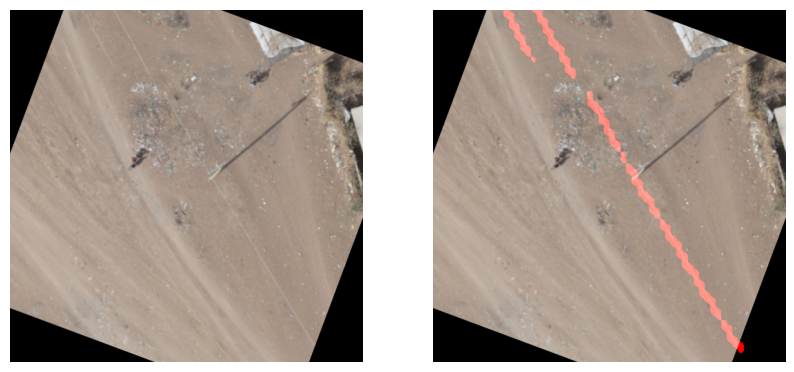

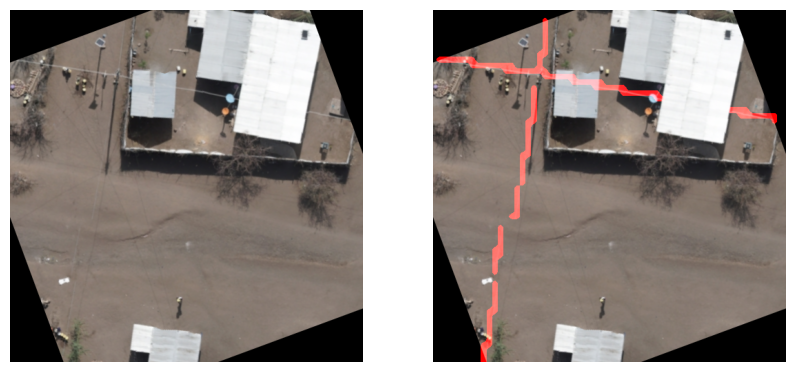

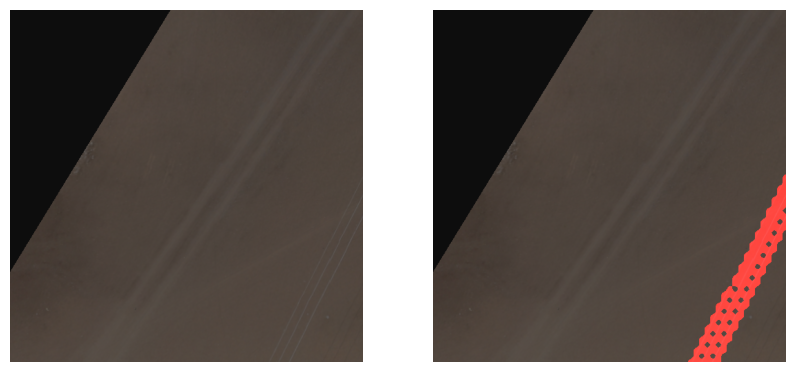

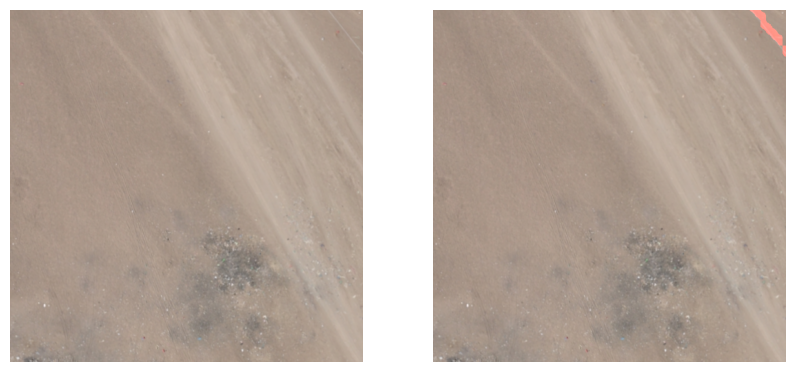

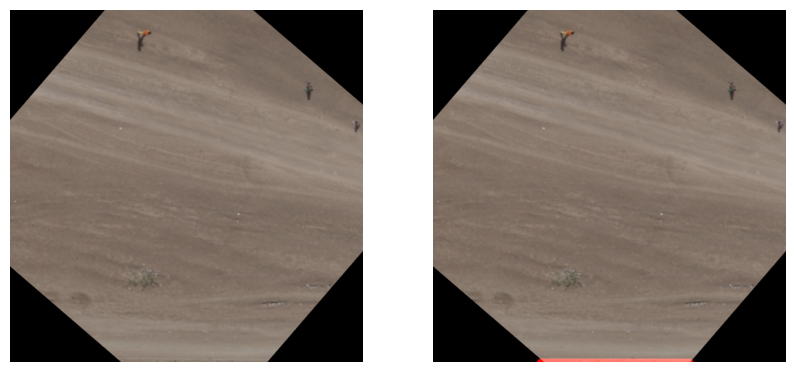

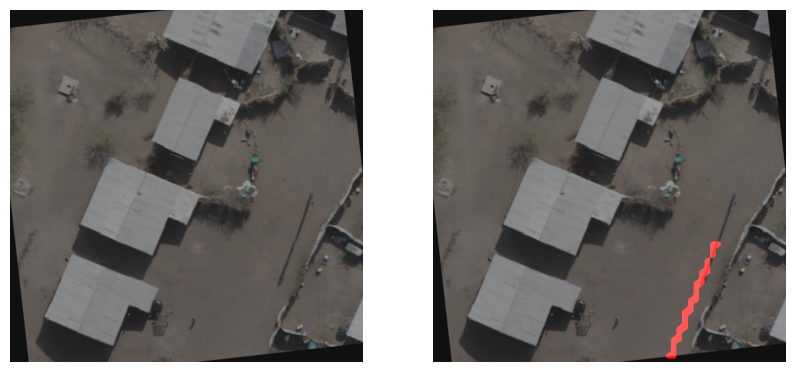

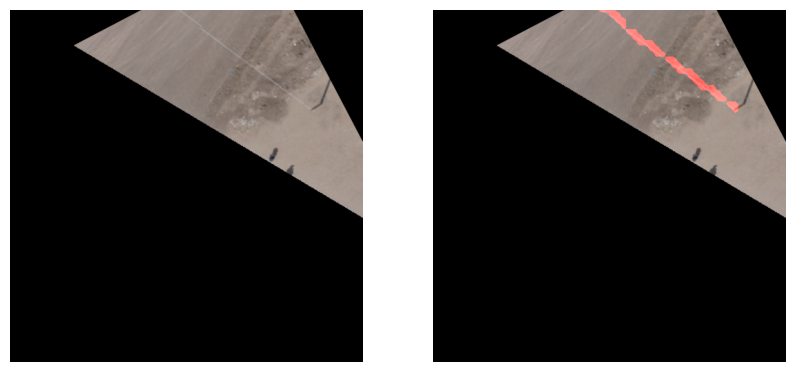

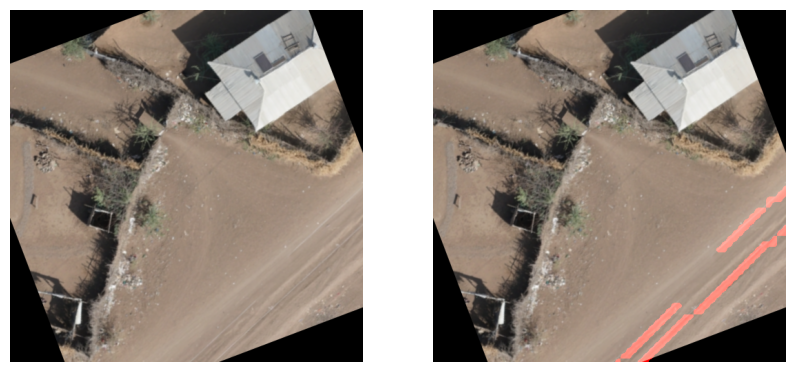

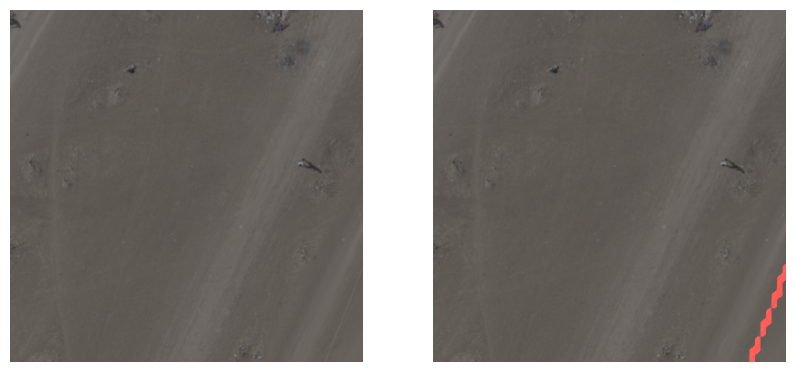

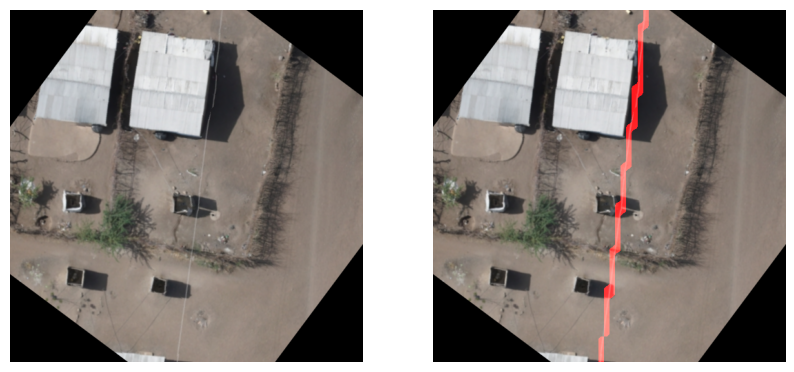

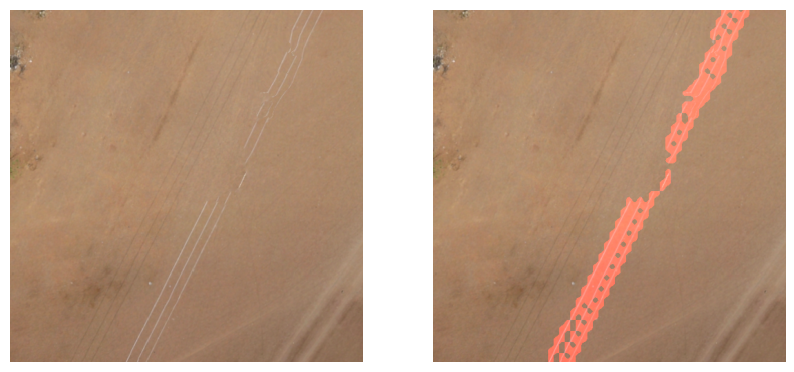

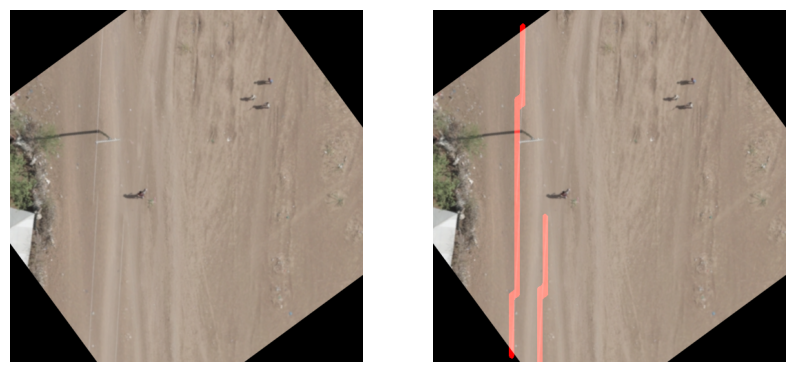

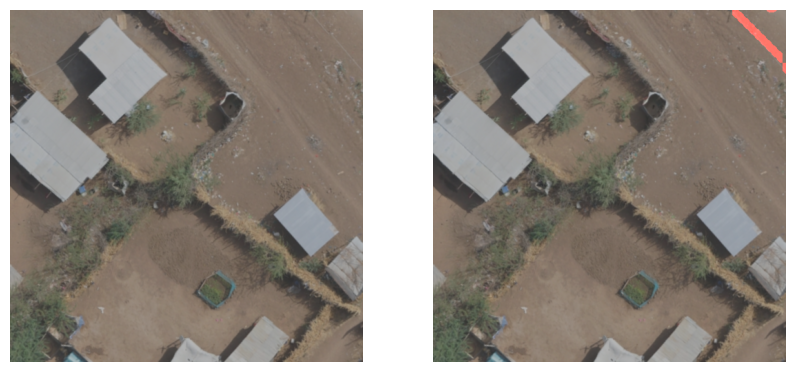

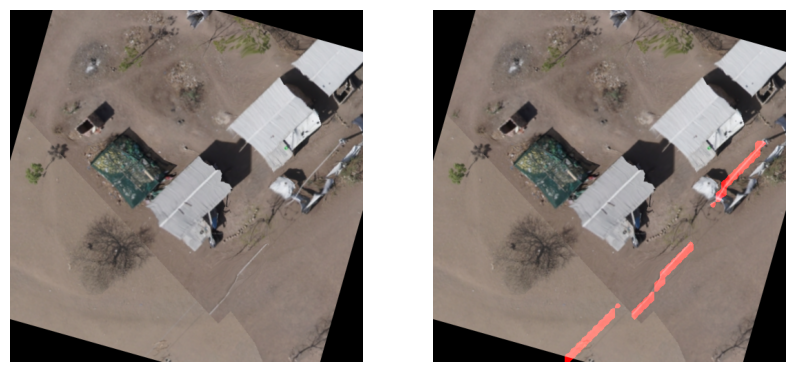

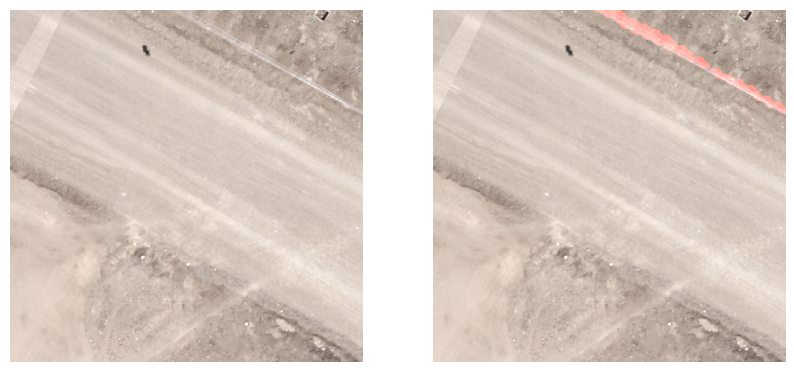

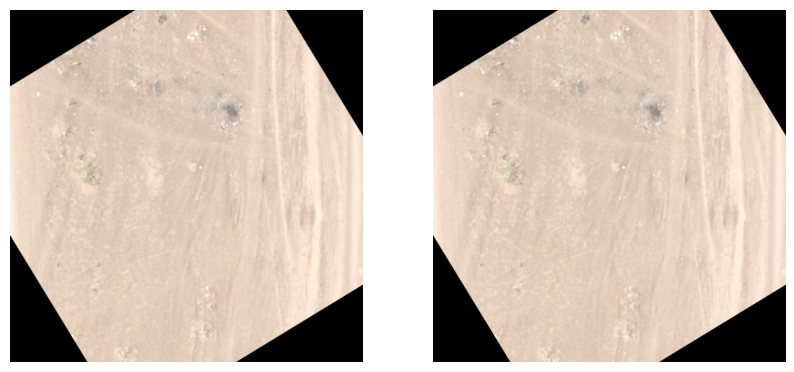

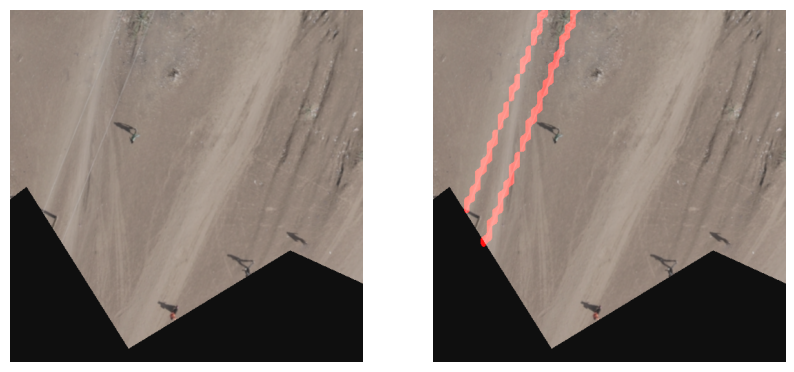

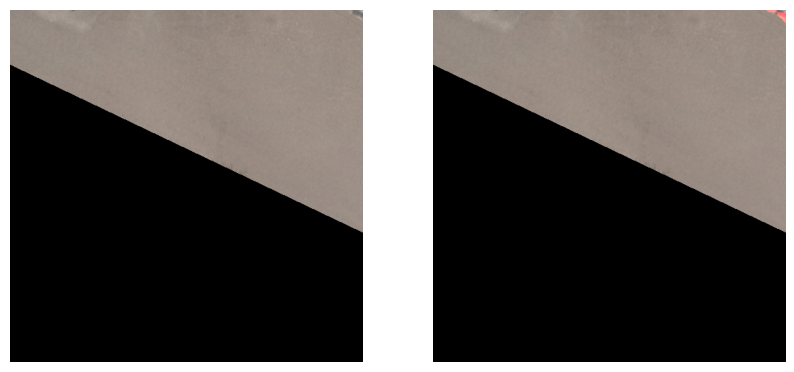

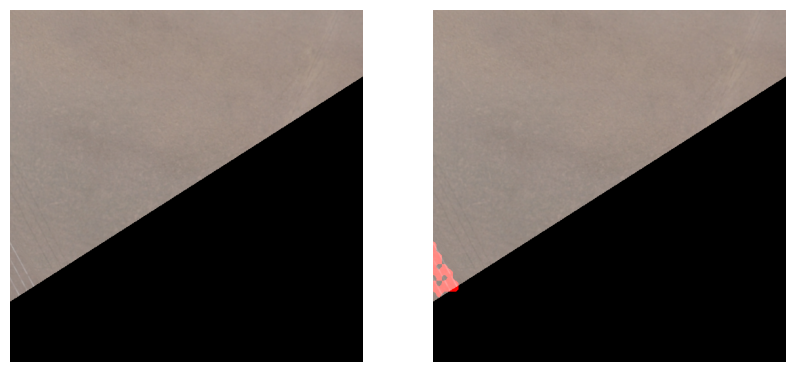

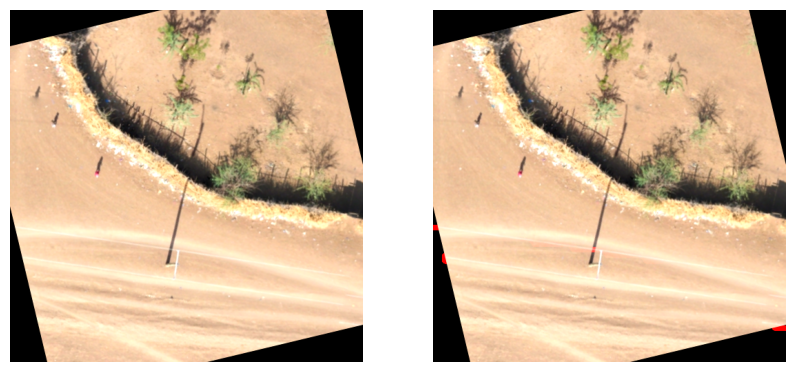

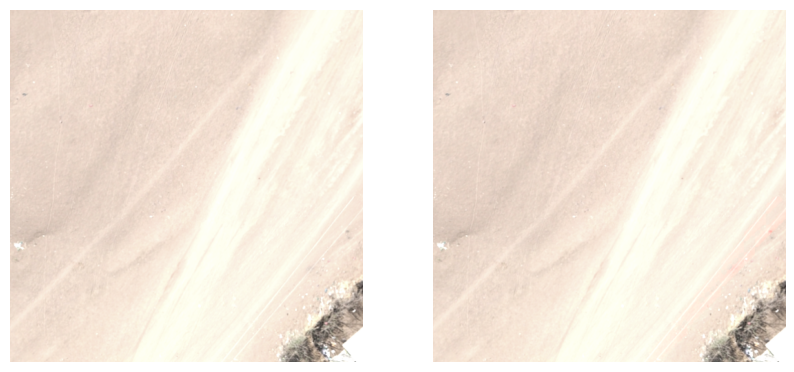

In [16]:
## let's zoom in actually for inspection
all_imgs, all_masks = np.concatenate(img[:25]), np.concatenate(mask[:25])
for idx, (tmp_img, tmp_mask) in enumerate(zip(all_imgs, all_masks)):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
    tmp_img = np.rollaxis(tmp_img, 0, 3)
    axs[0].imshow(tmp_img)
    axs[0].axis("off")
    new_img = tmp_img.copy()
    resized_mask = scipy.ndimage.zoom(np.rollaxis(tmp_mask, 0, 3)[:, :, 0], 8, order=1)
    new_img[resized_mask > 0.5, 0] = 1
    axs[1].imshow(new_img)
    axs[1].axis("off")
    plt.show()